In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root = "/home/sihartist/Desktop/"
path = root + "fraud-detection/dataset/preprocessing_data.xlsx"

In [3]:
# Load the credit card transaction data
df = pd.read_excel(path)
#df = pd.read_csv('/home/sihartist/Desktop/fraud-detection/algo/dataset/data_balanced.csv')

# df = pd.read_excel('/home/sihartist/Desktop/fraud-detection/algo/dataset/data_raw.xls', index_col=None, header=1) 
#df = df.iloc[:,1:]
#df = df.tail(-1)
df.head()

,V1,V2,V3,V4,V9,V10,V12,V13,V16,V19,...,V7_month,V7_day,V23_month,V23_day,V8_month,V8_day,V6_year,V7_year,V23_year,V8_year
0,4,2,23,1,285328,33443.0,19,2976,44,20238,...,0.201299,0.980307,0.201299,0.980307,-0.525049,-0.937752,2009,2009,2009,2009
1,4,2,23,1,483993,652487.0,19,2976,44,1352,...,0.201299,0.980307,0.201299,0.980307,-0.368810,0.937752,2009,2009,2009,2009
2,4,2,23,1,713040,554381.0,19,2976,44,25276,...,0.201299,0.980307,0.201299,0.980307,-0.893709,-0.937752,2009,2009,2009,2009
3,4,2,23,1,592014,778437.0,19,2976,44,24482,...,0.201299,0.980307,0.201299,0.980307,-0.996172,-0.937752,2009,2009,2009,2009
4,4,2,23,1,18805,314278.0,19,2976,44,16915,...,0.201299,0.980307,0.201299,0.980307,-0.996172,-0.937752,2009,2009,2009,2009


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140654 entries, 0 to 140653
Data columns (total 29 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   V1         140654 non-null  int64  
 1   V2         140654 non-null  int64  
 2   V3         140654 non-null  int64  
 3   V4         140654 non-null  int64  
 4   V9         140654 non-null  int64  
 5   V10        140654 non-null  float64
 6   V12        140654 non-null  int64  
 7   V13        140654 non-null  int64  
 8   V16        140654 non-null  int64  
 9   V19        140654 non-null  int64  
 10  V21        140654 non-null  int64  
 11  V22        140654 non-null  int64  
 12  V24        140654 non-null  int64  
 13  V25        140654 non-null  int64  
 14  V26        140654 non-null  int64  
 15  V27        140654 non-null  int64  
 16  CLASS      140654 non-null  int64  
 17  V6_month   140654 non-null  float64
 18  V6_day     140654 non-null  float64
 19  V7_month   140654 non-n

0    70327
1    70327
Name: CLASS, dtype: int64


<AxesSubplot:>

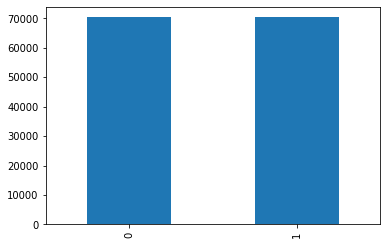

In [5]:
print(df.CLASS.value_counts())
df.CLASS.value_counts().plot(kind='bar')

In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [11]:
seed = 1337

def get_data(df, clean_train=True):
    """
        clean_train=True returns a train sample that only contains clean samples.
        Otherwise, it will return a subset of each class in train and test (10% outlier)
    """
    clean = df[df.CLASS == 0].copy().reset_index(drop=True)
    fraud = df[df.CLASS == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['CLASS'])], train.loc[:, train.columns.isin(['CLASS'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['CLASS'])], test.loc[:, test.columns.isin(['CLASS'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=0.2, random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=0.2, random_state=seed)
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['CLASS'])], train_samples.loc[:, train_samples.columns.isin(['CLASS'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['CLASS'])], test_samples.loc[:, test_samples.columns.isin(['CLASS'])]
    
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = get_data(df, False)

Clean Samples: 70327, Fraud Samples: 70327
Train Samples: 112522
Test Samples: 28132


In [12]:
model = IsolationForest(random_state=seed)
model.fit(train_X, train_y)

IsolationForest(random_state=1337)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
def predict(X):
    test_yhat = model.predict(X)
    # values are -1 and 1 (-1 for outliers and 1 for inliers), thus we will map it to 0 (inlier) and 1 (outlier) as this is our target variable
    test_yhat = np.array([1 if y == -1 else 0 for y in test_yhat])
    return test_yhat

test_yhat = predict(test_X)

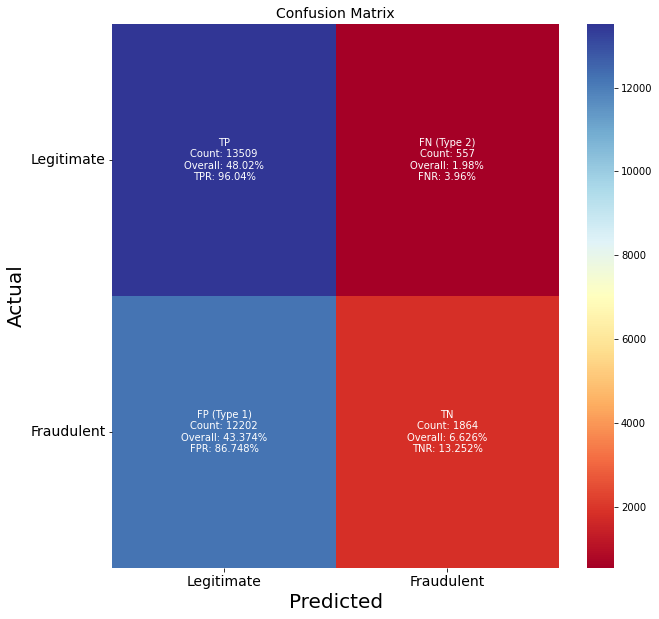

In [15]:
def get_confusion_matrix(test_y, test_yhat):
    cm = confusion_matrix(test_y, test_yhat)

    fig, ax = plt.subplots(1, 1,figsize=(10,10))

    tick_labels = ['Legitimate','Fraudulent']

    # calculate output
    total = np.sum(cm)
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    tp_o = np.round((tp / total)*100,3)
    fn_o = np.round((fn / total)*100,3)
    fp_o = np.round((fp / total)*100,3)
    tn_o = np.round((tn / total)*100,3)
    tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
    fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
    fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
    tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)
    labels = np.array([[
            f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%', 
            f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'
        ],[
            f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%', 
            f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%'
        ]])
    sns.heatmap(cm, ax=ax, annot=labels, fmt='', cmap=plt.cm.RdYlBu)

    ax.set_title('Confusion Matrix', fontsize=14)

    ax.set_xticklabels(tick_labels, fontsize=14, rotation=0)
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_yticklabels(tick_labels, fontsize=14, rotation=0)
    ax.set_ylabel('Actual', fontsize=20)
    plt.show()

get_confusion_matrix(test_y, test_yhat)


In [16]:
def get_classification_report(test_y, test_yhat):
    labels = ['Legitimate','Fraudulent']
    print(classification_report(test_y, test_yhat, target_names=labels))
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

  Legitimate       0.53      0.96      0.68     14066
  Fraudulent       0.77      0.13      0.23     14066

    accuracy                           0.55     28132
   macro avg       0.65      0.55      0.45     28132
weighted avg       0.65      0.55      0.45     28132

